In [198]:
#import modules
from EDA import Preprocessing
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from IPython.display import display
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC

In [199]:
#read datasets
import pandas as pd

df_mat = pd.read_csv('/home/pirate/Documents/machine_learning/score_prediction/student/student-mat.csv',sep=';')
df_por = pd.read_csv('/home/pirate/Documents/machine_learning/score_prediction/student/student-por.csv',sep=';')


In [200]:
#Handling duplicates found in datasets
df_merged=df_mat.append(df_por, ignore_index=True)
no_of_duplicates = df_merged.duplicated(["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]).sum()
print(f'---> We have {no_of_duplicates} duplicates found in our two datasets\n')

print('---> Merging datasets and removing duplicates\n')
df_merged.drop_duplicates(subset=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"],
                 keep = 'first', inplace = True)

print(f'---> After merging and removing duplicates we have {len(df_merged)} unique rows')

---> We have 382 found in our two datasets

---> Merging datasets and removing duplicates

---> After merging and removing duplicates we have 662 unique rows


In [201]:
                    # PERFORMING EDA
preprocessor = Preprocessing(df_merged)
#check for missing values
df = preprocessor.check_missing_value()

#check dataset descriptives
preprocessor.descriptives(df)

#perform data exploration
##separating dataset into categorical and continuous columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
continous_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

feature_list = list(df.columns)


---> No Missing Value was found data is clean and ready to use
---> Showing descriptive statistics of the dataset
               age        Medu        Fedu  traveltime   studytime  \
count   662.000000  662.000000  662.000000  662.000000  662.000000   
mean     16.812689    2.492447    2.293051    1.564955    1.927492   
std       1.269194    1.130958    1.094027    0.742799    0.827405   
min      15.000000    0.000000    0.000000    1.000000    1.000000   
25%      16.000000    2.000000    1.000000    1.000000    1.000000   
50%      17.000000    2.000000    2.000000    1.000000    2.000000   
75%      18.000000    4.000000    3.000000    2.000000    2.000000   
max      22.000000    4.000000    4.000000    4.000000    4.000000   
median   17.000000    2.000000    2.000000    1.000000    2.000000   
skew      0.422084   -0.006391    0.233855    1.253308    0.698354   
kurt     -0.031293   -1.254753   -1.088070    1.164596    0.039527   

          failures      famrel    freetime   

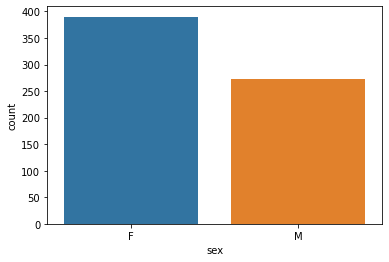

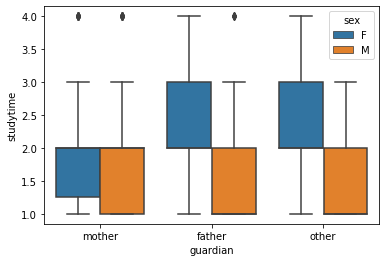

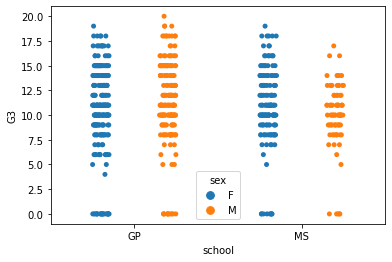

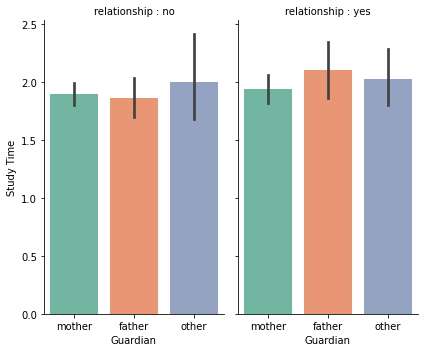

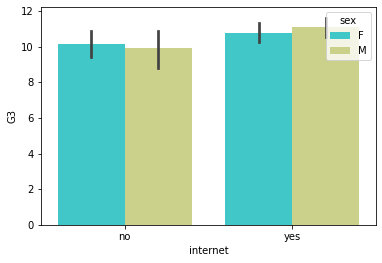

In [202]:
colors = sns.color_palette('pastel')[0:5]

#performing counts of catgorical variable levels for some variables
# sex_count_table = pd.crosstab(index=df['sex'], columns='freq')
sns.countplot(x ='sex', data = df)
plt.show()

sns.boxplot(x ='guardian', y ='studytime', data = df, hue ='sex')
plt.show()

sns.stripplot(x ='school', y ='G3', data = df, jitter = True, hue ='sex', dodge = True)
plt.show()

sns.pairplot(df, hue ="sex", palette ='coolwarm')
plt.show()

g = sns.catplot(x='guardian',y='studytime', col = 'romantic', data=df,
                kind='bar', aspect=.6, palette='Set2')
(g.set_axis_labels("Guardian", "Study Time")
  .set_titles("relationship : {col_name}"))
plt.show()

sns.barplot(x='internet',y='G3',data=df, palette='rainbow', hue='sex')
plt.show()


In [203]:
#DATASET ENCODING OF CATEGORICAL VARIABLES
df_copy = df.copy() #copying the dataset to preserve original copy
ord_enc = OrdinalEncoder() #encoder object

#looping through all the categorical columns initailly found and applying encoding on it
print('Performing EnCoding Of Categorical variables')
for col in categorical_columns:
    df_copy[col] = ord_enc.fit_transform(df_copy[[col]])
df_copy.head(10)

Performing EnCoding Of Categorical variables


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0.0,0.0,18,1.0,0.0,0.0,4,4,0.0,4.0,...,4,3,4,1,1,3,6,5,6,6
1,0.0,0.0,17,1.0,0.0,1.0,1,1,0.0,2.0,...,5,3,3,1,1,3,4,5,5,6
2,0.0,0.0,15,1.0,1.0,1.0,1,1,0.0,2.0,...,4,3,2,2,3,3,10,7,8,10
3,0.0,0.0,15,1.0,0.0,1.0,4,2,1.0,3.0,...,3,2,2,1,1,5,2,15,14,15
4,0.0,0.0,16,1.0,0.0,1.0,3,3,2.0,2.0,...,4,3,2,1,2,5,4,6,10,10
5,0.0,1.0,16,1.0,1.0,1.0,4,3,3.0,2.0,...,5,4,2,1,2,5,10,15,15,15
6,0.0,1.0,16,1.0,1.0,1.0,2,2,2.0,2.0,...,4,4,4,1,1,3,0,12,12,11
7,0.0,0.0,17,1.0,0.0,0.0,4,4,2.0,4.0,...,4,1,4,1,1,1,6,6,5,6
8,0.0,1.0,15,1.0,1.0,0.0,3,2,3.0,2.0,...,4,2,2,1,1,1,0,16,18,19
9,0.0,1.0,15,1.0,0.0,1.0,3,4,2.0,2.0,...,5,5,1,1,1,5,0,14,15,15


In [204]:
                        #REGRESSION
#splitting datasets into dependent and independent variables
X = df_copy.drop('G3',axis=1)
Y = df_copy['G3']

#splitting X, Y into train and test (80:20) ratio
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

# Convert to numpy array
X = np.array(X)

#show summary of splitted datasets
print("shape of original dataset :", df_copy.shape)
print("shape of input - training set", x_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", x_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (662, 33)
shape of input - training set (529, 32)
shape of output - training set (529,)
shape of input - testing set (133, 32)
shape of output - testing set (133,)


Mean Absolute Error: 0.9627819548872182
Mean Squared Error: 2.1474624060150376
Root Mean Squared Error: 1.4654222620170057
Accuracy: -inf
Variable: G2                   Importance: 0.81
Variable: absences             Importance: 0.07
Variable: age                  Importance: 0.01
Variable: reason               Importance: 0.01
Variable: guardian             Importance: 0.01
Variable: studytime            Importance: 0.01
Variable: activities           Importance: 0.01
Variable: famrel               Importance: 0.01
Variable: freetime             Importance: 0.01
Variable: health               Importance: 0.01
Variable: G1                   Importance: 0.01
Variable: school               Importance: 0.0
Variable: sex                  Importance: 0.0
Variable: address              Importance: 0.0
Variable: famsize              Importance: 0.0
Variable: Pstatus              Importance: 0.0
Variable: Medu                 Importance: 0.0
Variable: Fedu                 Importance: 0.0
Varia

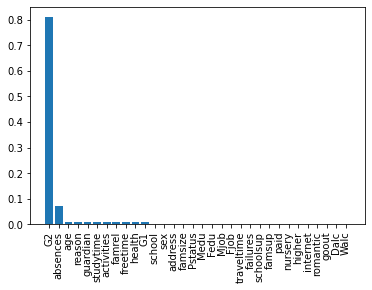

In [205]:
                            # Random Forest Regression
regressor = RandomForestRegressor(n_estimators = 20, random_state = 0)

# fit the regressor with x and y data
regressor.fit(x_train, y_train)

# Use the forest's predict method on the test data
y_pred = regressor.predict(x_test)
# Metrics
errors = abs(y_pred - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Accuracy:', accuracy)

# # Get numerical feature importances
importances = list(regressor.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# # Print out the feature and importances and plot them
x, y = zip(*feature_importances)
plt.xticks(rotation=90)
plt.bar(x, y)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

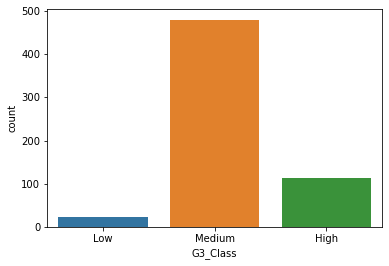

In [206]:
                            #CLASSIFICATION
#DIVIDE GRADE G3 INTO CLASSES 
"""
'Low' :- greater than 0 upto 6
'Medium' :- greater than 6 upto 14
'High' :- greater than 14 upto 20
"""
df_copy['G3_Class'] = pd.cut(x=df_copy['G3'], bins=[0,6,14,20], labels=['Low', 'Medium', 'High'])
# df_copy.head(20)

#plotting for class imbalance
sns.countplot('G3_Class', data=df_copy)

#class count
count_class_medium, count_class_high, count_class_low = df_copy['G3_Class'].value_counts()

# Divide by class
class_low = df_copy[df_copy['G3_Class'] == 'Low']
class_medium = df_copy[df_copy['G3_Class'] == 'Medium']
class_high = df_copy[df_copy['G3_Class'] == 'High']


Performing Over sampling technique to increase low class to medium class size while maintaining high class value
Low       480
Medium    480
High      113
Name: G3_Class, dtype: int64 

Performing Over sampling technique to increase low class to medium class size while maintaining high class value
Low       480
Medium    480
High      480
Name: G3_Class, dtype: int64 



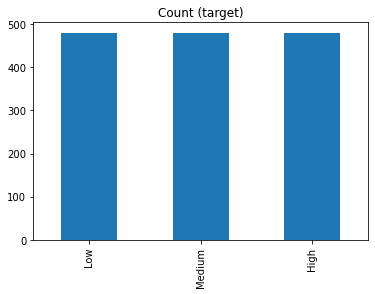

In [207]:
#Solving Class imbalance problem
                        ###using sampling method###

# Random Over-Sampling
class_low_over = class_low.sample(count_class_medium, replace=True)
df_low_over = pd.concat([class_medium, class_low_over], axis=0)
combined_dataset = df_low_over.append(class_high, ignore_index=True)
print('Performing Over sampling technique to increase low class to medium class size while maintaining high class value')
print(combined_dataset.G3_Class.value_counts(), '\n')

#class count
count_class_medium, count_class_low, count_class_high = combined_dataset['G3_Class'].value_counts()
# # Divide by class
class_low = combined_dataset[combined_dataset['G3_Class'] == 'Low']
class_medium = combined_dataset[combined_dataset['G3_Class'] == 'Medium']
class_high = combined_dataset[combined_dataset['G3_Class'] == 'High']

class_high_over = class_high.sample(count_class_medium, replace=True)
df_high_over = pd.concat([class_medium, class_high_over], axis=0)
dataset_final_sampling1 = df_high_over.append(class_low, ignore_index=True)
print('Performing Over sampling technique to increase low class to medium class size while maintaining high class value')
print(dataset_final_sampling1 .G3_Class.value_counts(),"\n")

#plotting dataset that has been sampled
dataset_final_sampling1.G3_Class.value_counts().plot(kind='bar', title='Count (target)');

In [208]:
#Encoding datasets and splitting datasets
#DATASET ENCODING OF CATEGORICAL VARIABLES
dataset_final_sampling1_copy = dataset_final_sampling1.copy() #copying the dataset to preserve original copy
ord_enc_new = OrdinalEncoder() #encoder object

#looping through all the categorical columns initailly found and applying encoding on it
print('Performing EnCoding Of Categorical variables')

dataset_final_sampling1_copy['G3_Class'] = ord_enc_new.fit_transform(dataset_final_sampling1_copy[['G3_Class']])
features = dataset_final_sampling1_copy.drop(['G3','G3_Class'],axis=1)
target = dataset_final_sampling1_copy['G3_Class']

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(features,target, test_size = 0.2, random_state = 10)

Performing EnCoding Of Categorical variables


In [209]:
#show summary of splitted datasets
print("shape of original dataset :", dataset_final_sampling1.shape)
print("shape of input - training set", x_train_new.shape)
print("shape of output - training set", y_train_new.shape)
print("shape of input - testing set", x_test_new.shape)
print("shape of output - testing set", y_test_new.shape)

shape of original dataset : (1440, 34)
shape of input - training set (1152, 32)
shape of output - training set (1152,)
shape of input - testing set (288, 32)
shape of output - testing set (288,)


In [210]:
##Support Vector Machine
svc_model = SVC(C= .1, kernel='poly', gamma= 1)
svc_model.fit(x_train_new, y_train_new)
  
y_pred = svc_model.predict(x_test_new)
# check the accuracy on the training set
print(svc_model.score(x_train_new, y_train_new))
print(svc_model.score(x_test_new, y_test_new))

print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_pred,y_test_new))
print(classification_report(y_test_new, y_pred, target_names=['low', 'medium', 'high']))

1.0
0.9826388888888888
Accuracy: 0.9826388888888888
Confusion Matrix:
 [[ 88   0   4]
 [  0 106   1]
 [  0   0  89]]
              precision    recall  f1-score   support

         low       0.96      1.00      0.98        88
      medium       0.99      1.00      1.00       106
        high       1.00      0.95      0.97        94

    accuracy                           0.98       288
   macro avg       0.98      0.98      0.98       288
weighted avg       0.98      0.98      0.98       288



In [211]:
#Random Forest Classfier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets
clf.fit(x_train_new,y_train_new)

#making predictions from test features
y_pred=clf.predict(x_test_new)

print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_pred,y_test_new))
print(classification_report(y_test_new, y_pred, target_names=['low', 'medium', 'high']))

Accuracy: 0.9895833333333334
Confusion Matrix:
 [[ 88   0   3]
 [  0 106   0]
 [  0   0  91]]
              precision    recall  f1-score   support

         low       0.97      1.00      0.98        88
      medium       1.00      1.00      1.00       106
        high       1.00      0.97      0.98        94

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



In [212]:
#Multi Layer Perception Neural Network
# Create model object
MLP_net = MLPClassifier(hidden_layer_sizes=(6,5),
                    verbose=False,
                    learning_rate_init=0.01)

# Fit data onto the model
MLP_net.fit(x_train_new,y_train_new)
y_pred=MLP_net.predict(x_test_new)

# Calcuate accuracy
print("Accuracy:",accuracy_score(y_test_new,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_pred,y_test_new))
print(classification_report(y_test_new, y_pred, target_names=['low', 'medium', 'high']))

Accuracy: 0.9618055555555556
Confusion Matrix:
 [[ 84   0   5]
 [  0 106   2]
 [  4   0  87]]
              precision    recall  f1-score   support

         low       0.94      0.95      0.95        88
      medium       0.98      1.00      0.99       106
        high       0.96      0.93      0.94        94

    accuracy                           0.96       288
   macro avg       0.96      0.96      0.96       288
weighted avg       0.96      0.96      0.96       288

